In [1]:
import $file.scripts.importer

importer.loadProjectDependencies

import $file.$               



In [2]:
import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._
import edu.stanford.math.plex4.streams.impl.LazyWitnessStream

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.mean
import breeze.util.JavaArrayOps

import tda.persistence.Analysis._
import tda.persistence.Math._

def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}


import scala.collection.JavaConverters._

import scala.collection.JavaConversions._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._

import edu.stanford.math.plex4.streams.impl.LazyWitnessStream


import breeze.numerics._

import breeze.linalg._

import breeze.math._

import breeze.stats.mean

import breeze.util.JavaArrayOps


import tda.persistence.Analysis._

import tda.persistence.Math._


defined function drawBarcodes

In [3]:
lazy val digitsRawData = csvread(importer.loadData("digits.csv"))
lazy val digitsData = digitsRawData(*, Range(0, digitsRawData.cols - 1)).underlying 

lazy val digitsDataArray = JavaArrayOps.dmDToArray2(digitsData)

digitsRawData: DenseMatrix[Double] = <lazy>
digitsData: DenseMatrix[Double] = <lazy>
digitsDataArray: Array[Array[Double]] = <lazy>

## Full dataset homology 

In [4]:
lazy val (maxDimension, maxFiltrationValue, numDivisions) = (5, 15, 50)

lazy val digitsStream = Plex4.createVietorisRipsStream(digitsDataArray, maxDimension, maxFiltrationValue, numDivisions)

lazy val (digitsIntervals, digitsImages) = intervalsWithImages(
  digitsStream,
  maxDimension,
  maxFiltrationValue,
  defaultPersistenceAlgorithm(maxDimension))

maxDimension: Int = <lazy>
maxFiltrationValue: Int = <lazy>
numDivisions: Int = <lazy>
digitsStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
digitsIntervals: BarcodeCollection[java.lang.Double] = <lazy>
digitsImages: List[java.awt.image.BufferedImage] = <lazy>

In [5]:
println(Seq(
  "Digits simplex stream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${digitsStream.getSize()} simplices").mkString("\n"))

Digits simplex stream for
maxFiltrationValue = 15
has 94824 simplices


## Reduced dataset's homology 

In [6]:
val noLandmarkPoints = 75 

lazy val digitsLandmarksSelector = Plex4
  .createMaxMinSelector(digitsDataArray, noLandmarkPoints)

val epsilon = digitsLandmarksSelector.getMaxDistanceFromPointsToLandmarks

lazy val digitsLandmarksIndices = digitsLandmarksSelector
  .getLandmarkPoints()

lazy val digitsLandmarks = digitsLandmarksIndices
  .map(digitsDataArray(_))

val closestDist = dist(DenseMatrix(digitsLandmarks: _*), DenseMatrix(digitsLandmarks: _*))
  .toDenseVector.toArray.filter(_ > 0).min

Feb 10, 2017 8:41:29 PM com.github.fommil.jni.JniLoader liberalLoad
INFO: successfully loaded /tmp/jniloader3287009519332806804netlib-native_system-linux-x86_64.so


noLandmarkPoints: Int = 75
digitsLandmarksSelector: metric.landmark.MaxMinLandmarkSelector[Array[Double]] = <lazy>
epsilon: Double = 38.157568056677825
digitsLandmarksIndices: Array[Int] = <lazy>
digitsLandmarks: Array[Array[Double]] = <lazy>
closestDist: Double = 1462.0

In [7]:
lazy val (maxDimension, numDivisions) = 
         (10          , 100)

val landmarksMaxFiltrationValue = epsilon * 1.33

lazy val digitsLandmarksStream = Plex4.createVietorisRipsStream(digitsLandmarks, maxDimension, landmarksMaxFiltrationValue, numDivisions)

lazy val (digitsIntervals, digitsLandmarksImages) = intervalsWithImages(
  digitsLandmarksStream,
  maxDimension,
  landmarksMaxFiltrationValue,
  defaultPersistenceAlgorithm(maxDimension))

maxDimension: Int = <lazy>
numDivisions: Int = <lazy>
landmarksMaxFiltrationValue: Double = 50.74956551538151
digitsLandmarksStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
digitsIntervals: BarcodeCollection[java.lang.Double] = <lazy>
digitsLandmarksImages: List[java.awt.image.BufferedImage] = <lazy>

In [8]:
println(Seq(
  "Reduced simplex stream for",
  s"maxFiltrationValue = ${landmarksMaxFiltrationValue}",
  s"on ${'\u03B5'}-net for ${'\u03B5'} = ${digitsLandmarksSelector.getMaxDistanceFromPointsToLandmarks}",
  s"and has ${digitsLandmarksStream.getSize()} simplices").mkString("\n"))

Reduced simplex stream for
maxFiltrationValue = 50.74956551538151
on ε-net for ε = 38.157568056677825
and has 56180 simplices


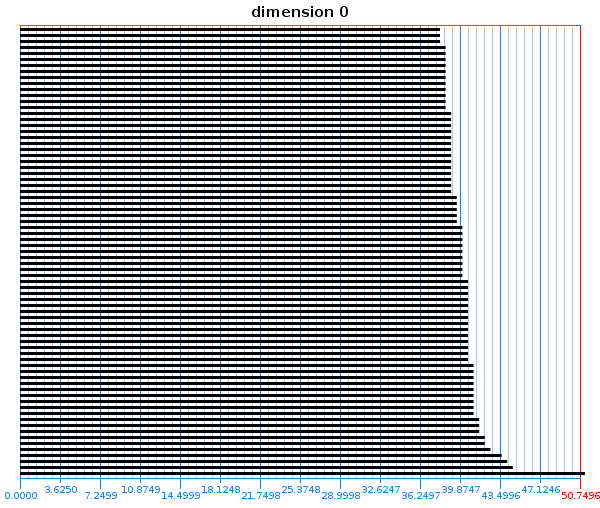

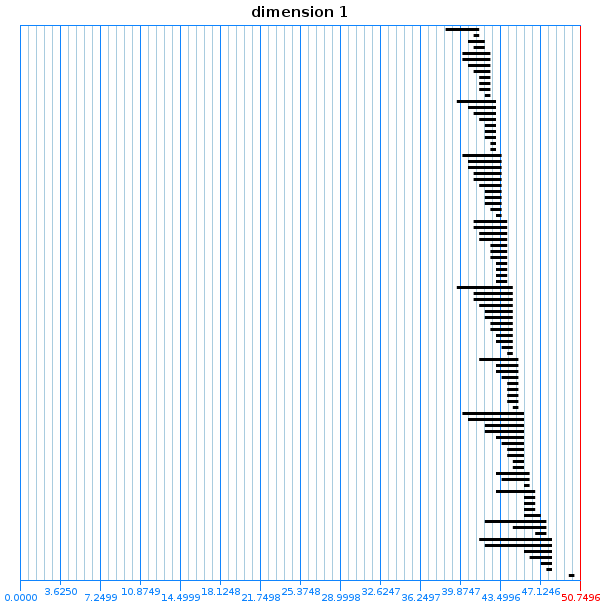

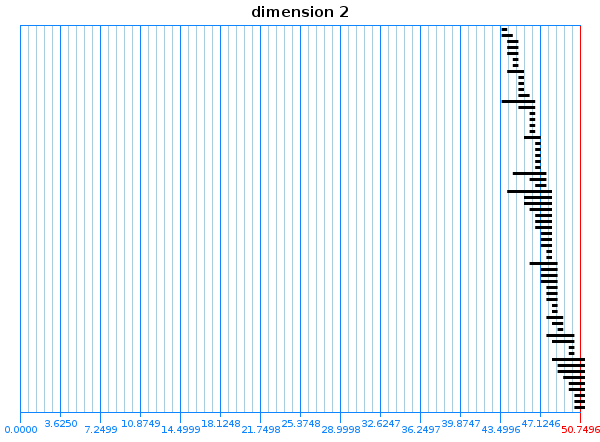

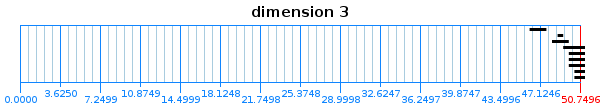

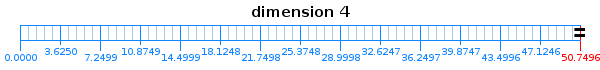

In [9]:
drawBarcodes(digitsLandmarksImages)

In [10]:
lazy val dists = dist(digitsData, digitsData)

dists.toDenseVector.toArray.filter(_ > 15).min
mean(dists)
max(dists)

dists: DenseMatrix[Double] = <lazy>
res9_1: Double = 28.0
res9_2: Double = 2407.7248475835613
res9_3: Double = 6419.0

## Lazy witness complex homology 

In [11]:
def lazyWitnessHomologyIntervals(noWitnesses: Int, noLandmarkPoints: Int, thr: Double) = {
  lazy val witnesses = subsampleRandom(noWitnesses, digitsDataArray)

  lazy val selector = Plex4
    .createMaxMinSelector(witnesses, noLandmarkPoints)

  val witnessFiltrationValue = thr  * selector.getMaxDistanceFromPointsToLandmarks 

  lazy val digitsWitnessStream = new LazyWitnessStream(
    selector.getUnderlyingMetricSpace,
    selector,
    maxDimension,
    witnessFiltrationValue,
    1,
    numDivisions)

  digitsWitnessStream.finalizeStream()
  
  println(Seq(
    "Digits simplex stream for",
    s"maxFiltrationValue = ${witnessFiltrationValue}",
    s"is ${'\u03B5'}-net for ${'\u03B5'} = ${selector.getMaxDistanceFromPointsToLandmarks}",
    s"and has ${digitsWitnessStream.getSize()} simplices", "").mkString("\n"))
  intervalsWithImages(
    digitsWitnessStream,
    maxDimension,
    witnessFiltrationValue,
    defaultPersistenceAlgorithm(maxDimension))
}

defined function lazyWitnessHomologyIntervals

Digits simplex stream for
maxFiltrationValue = 5.6000000000000005
is ε-net for ε = 28.0
and has 734 simplices



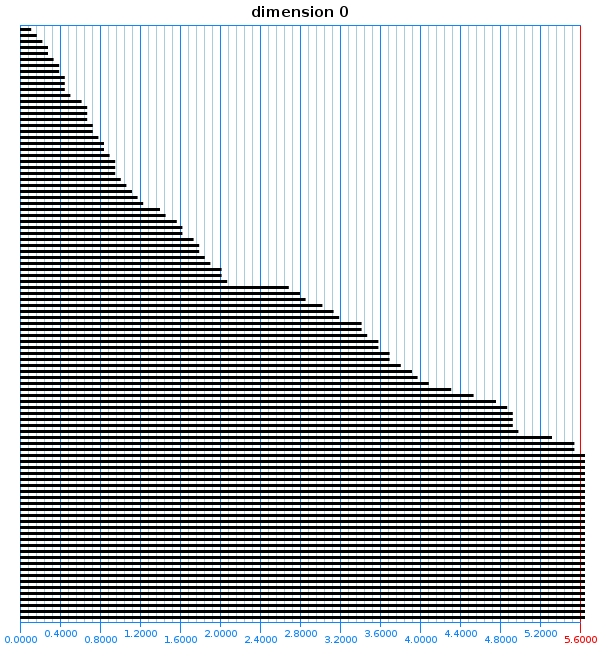

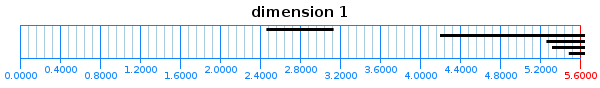

digitsWitnessIntervals: BarcodeCollection[java.lang.Double] = <lazy>
digitsWitnessImages: List[java.awt.image.BufferedImage] = <lazy>

In [22]:
lazy val (digitsWitnessIntervals, digitsWitnessImages) = 
  lazyWitnessHomologyIntervals(250, 100, 0.2)

drawBarcodes(digitsWitnessImages)

Digits simplex stream for
maxFiltrationValue = 5.617828762075256
is ε-net for ε = 28.089143810376278
and has 1003 simplices

Digits simplex stream for
maxFiltrationValue = 5.751521537819363
is ε-net for ε = 28.75760768909681
and has 1175 simplices

Digits simplex stream for
maxFiltrationValue = 5.517245689653489
is ε-net for ε = 27.586228448267445
and has 1465 simplices

Digits simplex stream for
maxFiltrationValue = 5.535341001239219
is ε-net for ε = 27.676705006196094
and has 889 simplices

Digits simplex stream for
maxFiltrationValue = 5.74108003776293
is ε-net for ε = 28.705400188814647
and has 3755 simplices

Digits simplex stream for
maxFiltrationValue = 5.6035702904487605
is ε-net for ε = 28.0178514522438
and has 600 simplices

Digits simplex stream for
maxFiltrationValue = 5.642694391866354
is ε-net for ε = 28.21347195933177
and has 1644 simplices

Digits simplex stream for
maxFiltrationValue = 5.628498911788116
is ε-net for ε = 28.142494558940577
and has 840 simplices

Digits 

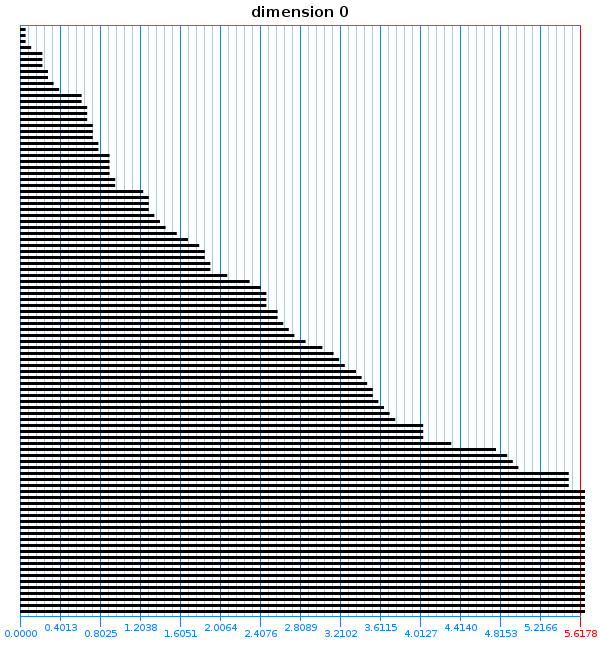

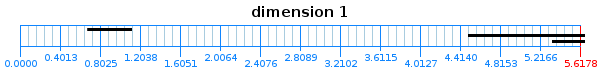

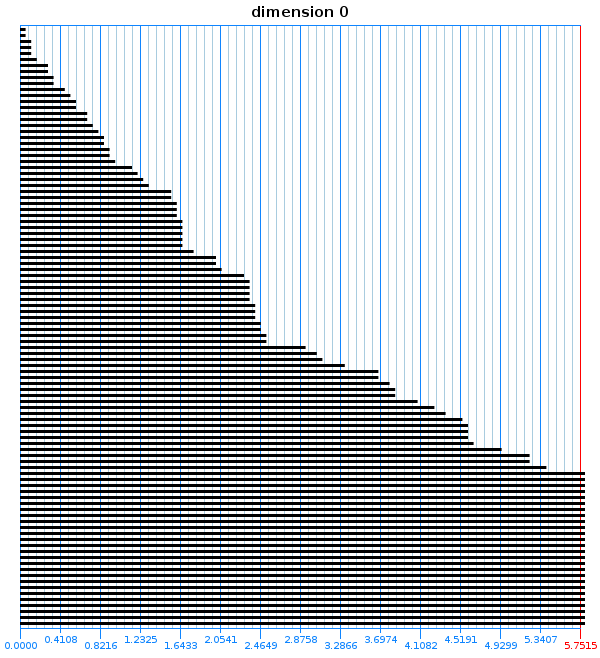

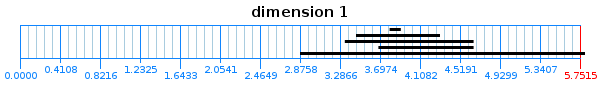

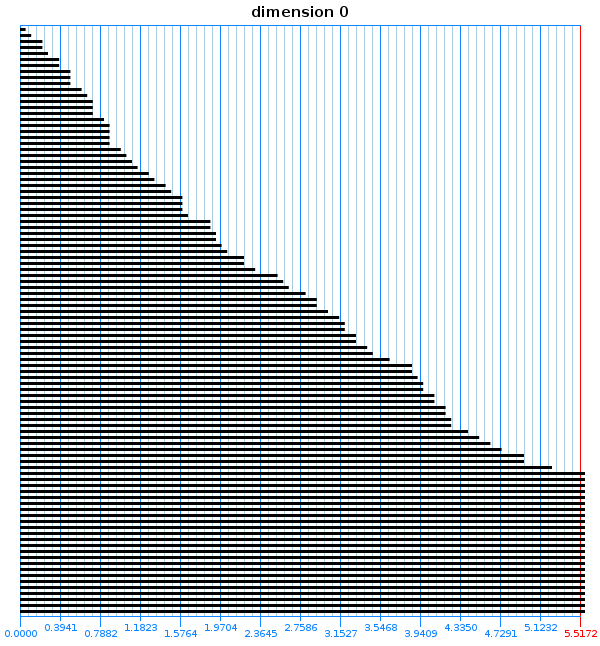

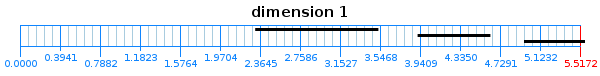

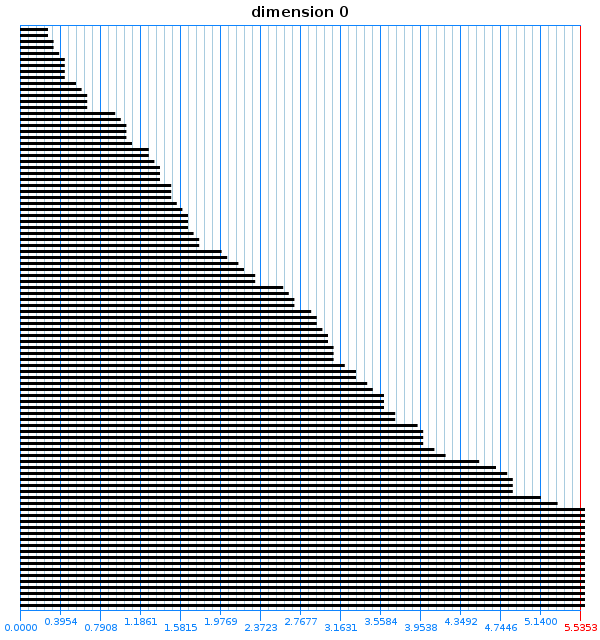

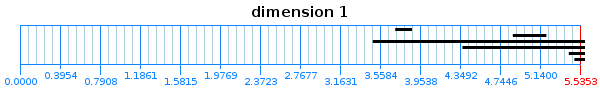

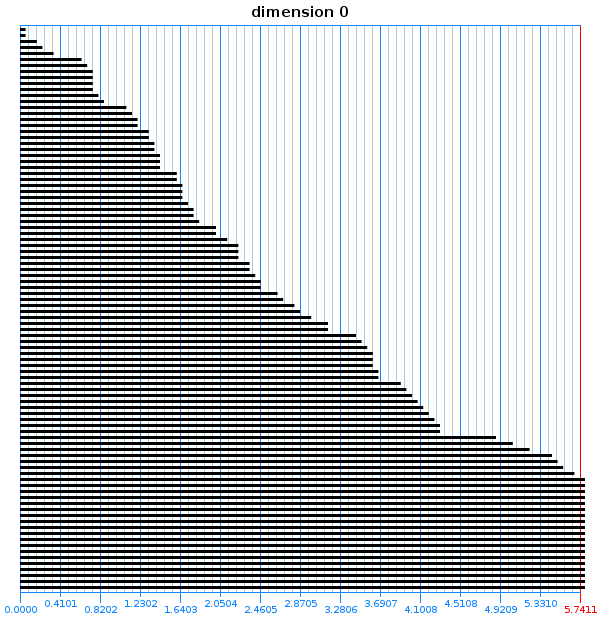

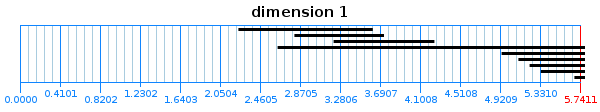

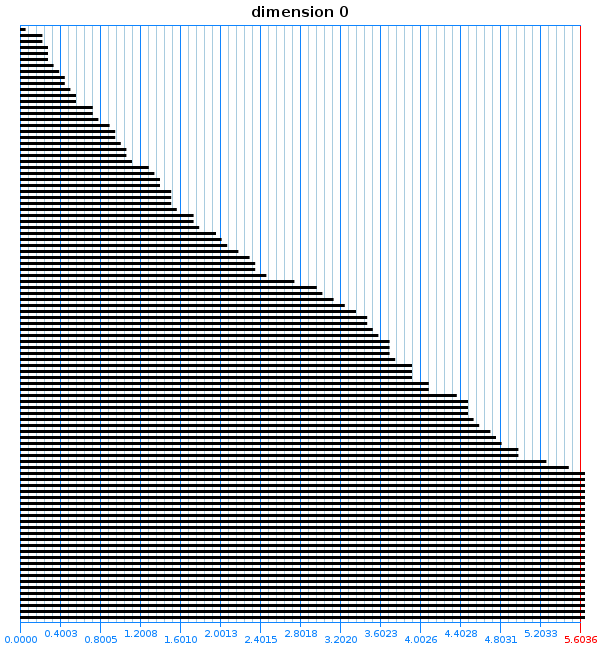

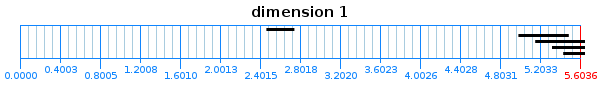

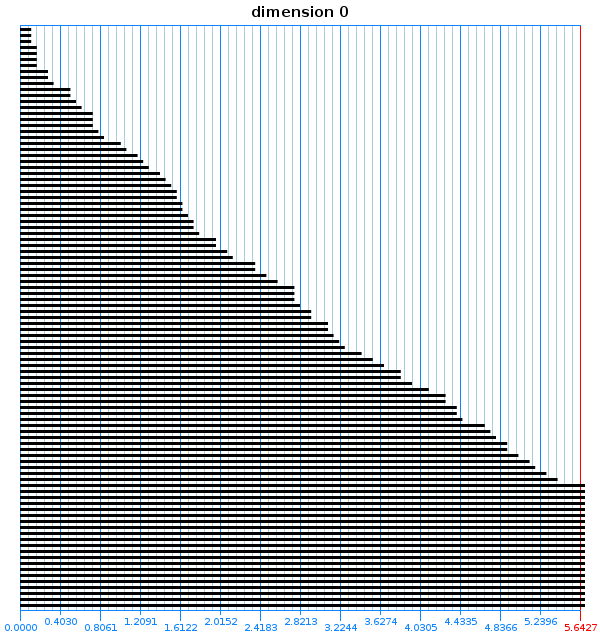

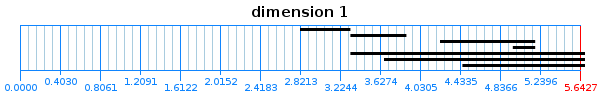

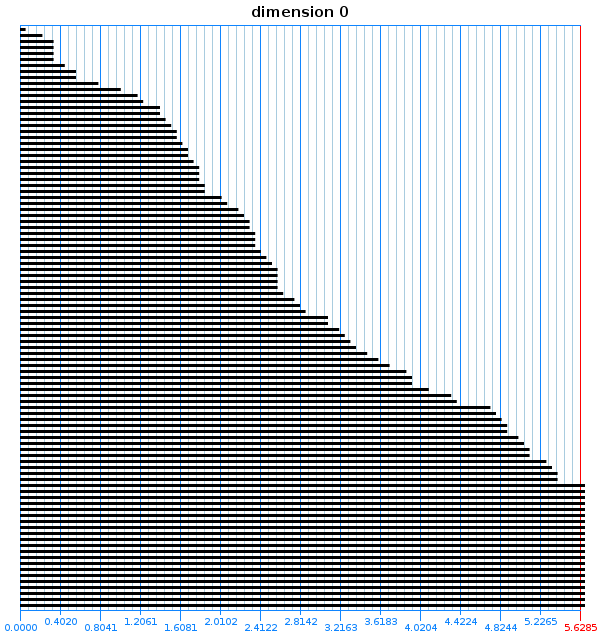

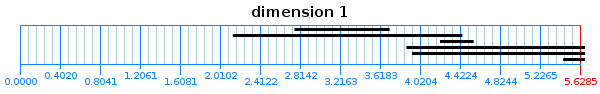

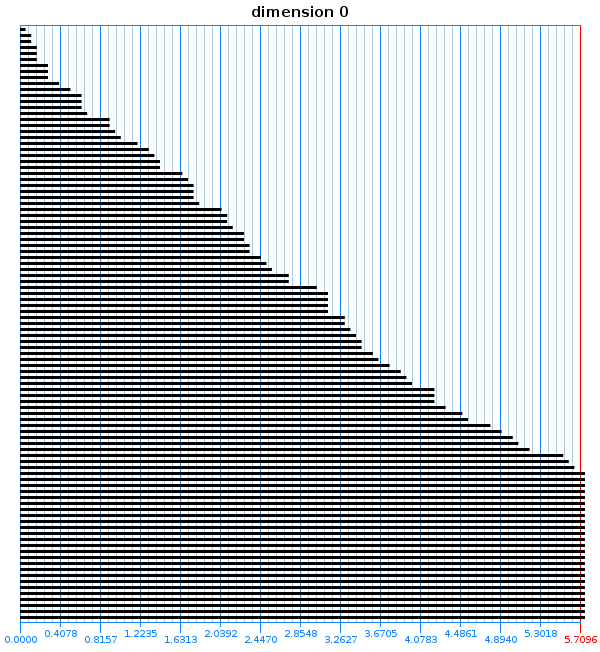

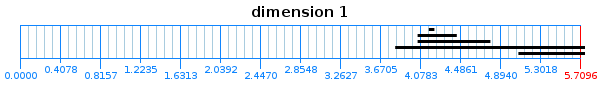

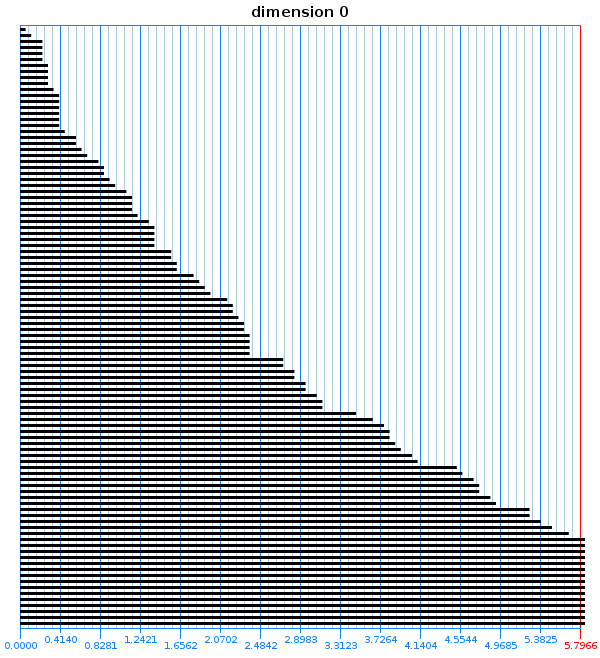

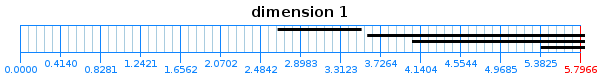

barcodeSamples: Seq[(BarcodeCollection[java.lang.Double], List[java.awt.image.BufferedImage])] = <lazy>

In [25]:
lazy val barcodeSamples = Seq.fill(10)((250, 100, 0.2))
  .map(lazyWitnessHomologyIntervals _ tupled)
  
barcodeSamples.foreach { case (_, images) =>
  drawBarcodes(images)
}